# Afternoon: Introduction to Spatial Analysis

In [10]:
rm(list=ls())
library(nlme)
library(fields)
library(geoR)
library(colorRamps)
rmat90 <- function(x) t(apply(x, 2, rev))

Warning message:
"package 'geoR' was built under R version 3.3.3"--------------------------------------------------------------
 Analysis of Geostatistical Data
 For an Introduction to geoR go to http://www.leg.ufpr.br/geoR
 geoR version 1.7-5.2 (built on 2016-05-02) is now loaded
--------------------------------------------------------------



## What generates the pattern?

## Simulate spatially correlated data

In [12]:
M  	<- expand.grid(1:30, 1:30)
n  	<- nrow(M)
D  	<- as.matrix(dist(M))
r  	<- 0.1
s  	<- 10
S 	<- s^2*exp(-r*D)
L  <- chol(S)
Si <- chol2inv(L)
Li <- solve(L)

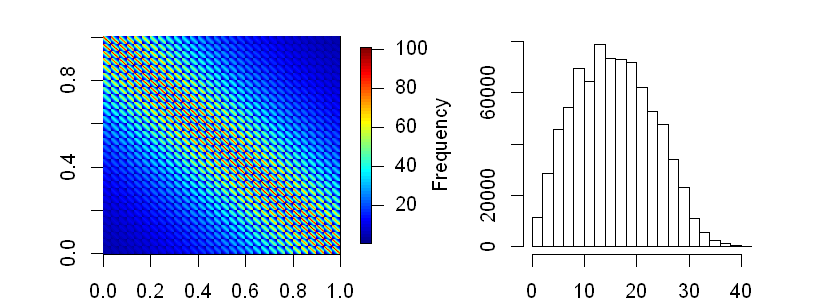

In [15]:
options(repr.plot.width=7, repr.plot.height=2.5)
par(mfrow=c(1,2))
image.plot(rmat90(S))
hist(c(D))

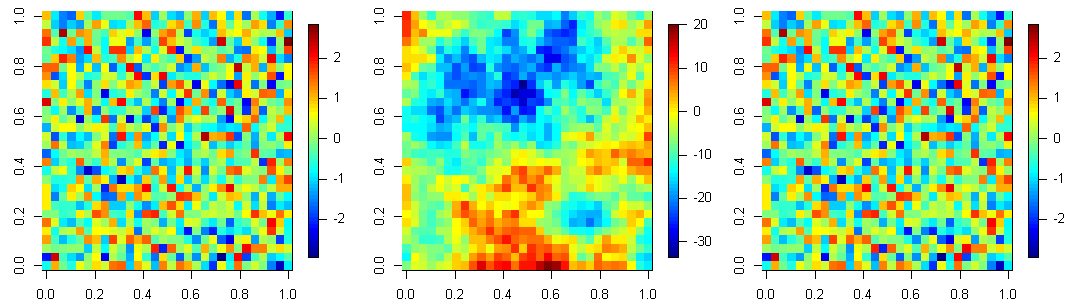

In [27]:
x0  <- matrix(rnorm(n), ncol=n)
x   <- x0%*%L
x00 <- x%*%Li

options(repr.plot.width=9, repr.plot.height=2.5)
par(mfrow=c(1,3),mar=c(5,2,2,2))
image.plot(as.matrix(xtabs(t(x0)  ~ M[,1] + M[,2])))
image.plot(as.matrix(xtabs(t(x)   ~ M[,1] + M[,2])))
image.plot(as.matrix(xtabs(t(x00) ~ M[,1] + M[,2])))

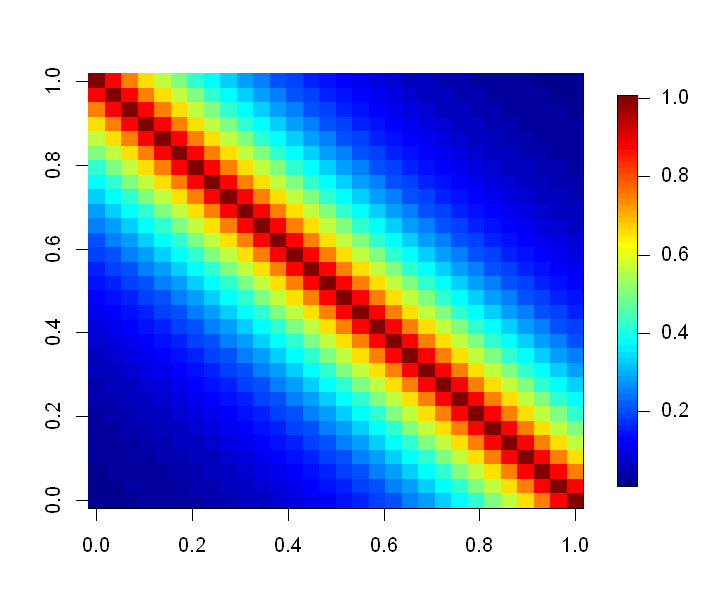

In [67]:
dat <- data.frame(lat=seq(1,30),lon=seq(1,30))
Sexp <- corExp(10, form = ~ lat + lon )
Sexp <- Initialize(Sexp, dat)
#round(corMatrix(Sexp)[1:10,1:10],7)
#dim(corMatrix(Sexp))

options(repr.plot.width=6, repr.plot.height=5)
image.plot(rmat90(corMatrix(Sexp)))

## Spatial Interpolation

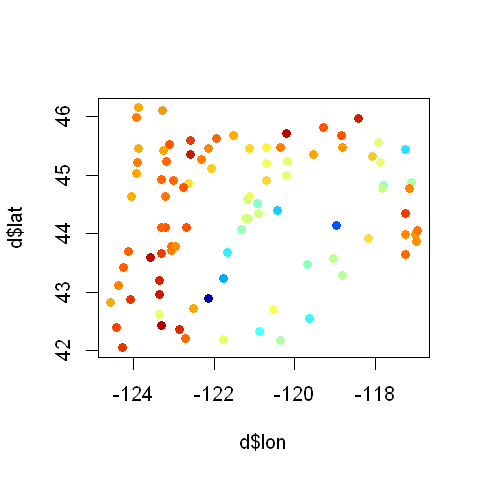

In [24]:
d <- read.csv('D:/Dropbox/Teaching/Bayes/DSI/Environmental_Stats_with_Stan/Data/oregon_temp_precip.csv',header=TRUE,stringsAsFactors=FALSE)
cols <- matlab.like(100)[as.numeric(cut(d$temp_annual,breaks=100))]
options(repr.plot.width=4, repr.plot.height=4)
plot(d$lon,d$lat,col=cols,pch=19)

In [23]:
y      <- d$temp_annual
latlon <- cbind(d$lon,d$lat)
s_obs  <- 2
fit <- likfit(data=y,coords=latlon,
	fix.nugget=TRUE,
	cov.model="exponential",
	ini=c(30,5),
	nugget=s_obs, 
	lik.method = "ML")
phi_hat <- fit$cov.pars[2]
s2_hat <- fit$cov.pars[1]

lon0    <- seq(min(latlon[,1]),max(latlon[,1]),length=100)
lat0    <- seq(min(latlon[,2]),max(latlon[,2]),length=100)
latlon0 <-expand.grid(lon0,lat0)
pred <- krige.conv(data=y,
				   coords=latlon,
				   locations=latlon0,
				   krige=krige.control(cov.model="exponential",
					cov.pars=c(s2_hat,phi_hat),nugget=s_obs)
)

kappa not used for the exponential correlation function
---------------------------------------------------------------
likfit: likelihood maximisation using the function optim.
likfit: Use control() to pass additional
         arguments for the maximisation function.
        For further details see documentation for optim.
likfit: It is highly advisable to run this function several
        times with different initial values for the parameters.
likfit: WARNING: This step can be time demanding!
---------------------------------------------------------------
likfit: end of numerical maximisation.
krige.conv: model with constant mean
krige.conv: Kriging performed using global neighbourhood 


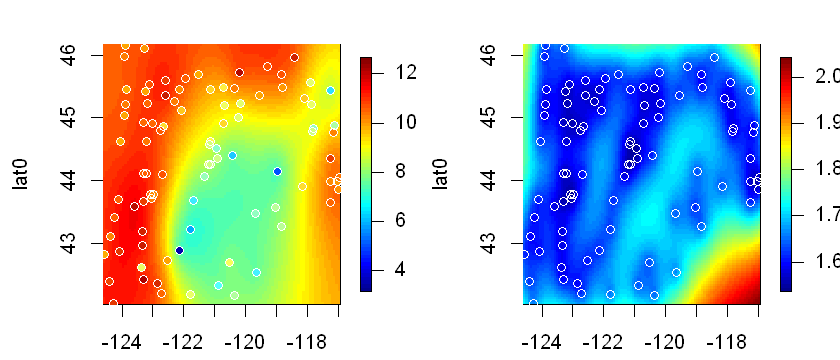

In [21]:
options(repr.plot.width=7, repr.plot.height=3)
par(mfrow=c(1,2))	
image.plot(lon0,lat0,matrix(pred$predict,100,100),zlim=range(y))
	cols <- matlab.like(100)[as.numeric(cut(y,breaks=100))]
	points(latlon,col=cols,pch=19)
	points(latlon,col='white')
image.plot(lon0,lat0,matrix(sqrt(pred$krige.var),100,100))
points(latlon,col='white')

## Spatial regression

In [27]:
d[1:3,]

station,lat,lon,elevation,temp_jan,temp_jul,temp_annual,precip_jan,precip_jul,precip_ann,county
ANT,44.917,-120.717,846,0.0,20.2,9.6,41,9,322,ANTELOPE 1 N USA-OR
ARL,45.717,-120.200,96,0.9,24.6,12.5,40,6,228,ARLINGTON USA-OR
ASH,42.217,-122.717,543,3.1,20.8,11.1,70,7,480,ASHLAND 1 N USA-OR


In [25]:
fit <- gls(precip_ann ~ temp_annual, data=d, correlation=corExp(form=~lat+lon,nugget=FALSE),method='ML')
summary(fit)

Generalized least squares fit by maximum likelihood
  Model: precip_ann ~ temp_annual 
  Data: d 
       AIC      BIC    logLik
  1297.666 1307.753 -644.8329

Correlation Structure: Exponential spatial correlation
 Formula: ~lat + lon 
 Parameter estimate(s):
   range 
6.072546 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 1825.4297  711.1956  2.566706  0.0119
temp_annual  -71.6271   20.8419 -3.436694  0.0009

 Correlation: 
            (Intr)
temp_annual -0.303

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.2982015 -0.9274755 -0.6598595  0.3166358  1.5576293 

Residual standard error: 917.6314 
Degrees of freedom: 92 total; 90 residual

In [28]:
fit2 <- gls(precip_ann ~ temp_annual + elevation, data=d, correlation=corExp(form=~lat+lon,nugget=FALSE),method='ML')
summary(fit)

Generalized least squares fit by maximum likelihood
  Model: precip_ann ~ temp_annual 
  Data: d 
       AIC      BIC    logLik
  1297.666 1307.753 -644.8329

Correlation Structure: Exponential spatial correlation
 Formula: ~lat + lon 
 Parameter estimate(s):
   range 
6.072546 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 1825.4297  711.1956  2.566706  0.0119
temp_annual  -71.6271   20.8419 -3.436694  0.0009

 Correlation: 
            (Intr)
temp_annual -0.303

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.2982015 -0.9274755 -0.6598595  0.3166358  1.5576293 

Residual standard error: 917.6314 
Degrees of freedom: 92 total; 90 residual

In [29]:
y      <- predict(fit2)
latlon <- cbind(d$lon,d$lat)
fit <- likfit(data=y,coords=latlon,
	fix.nugget=TRUE,
	cov.model="exponential",
	ini=c(30,5),
	nugget=FALSE, 
	lik.method = "ML")
phi_hat <- fit$cov.pars[2]
s2_hat <- fit$cov.pars[1]

lon0    <- seq(min(latlon[,1]),max(latlon[,1]),length=100)
lat0    <- seq(min(latlon[,2]),max(latlon[,2]),length=100)
latlon0 <-expand.grid(lon0,lat0)
pred <- krige.conv(data=y,
				   coords=latlon,
				   locations=latlon0,
				   krige=krige.control(cov.model="exponential",
					cov.pars=c(s2_hat,phi_hat),nugget=s_obs)
)

kappa not used for the exponential correlation function
---------------------------------------------------------------
likfit: likelihood maximisation using the function optimize.
likfit: Use control() to pass additional
         arguments for the maximisation function.
        For further details see documentation for optimize.
likfit: It is highly advisable to run this function several
        times with different initial values for the parameters.
likfit: WARNING: This step can be time demanding!
---------------------------------------------------------------
likfit: end of numerical maximisation.
krige.conv: model with constant mean
krige.conv: Kriging performed using global neighbourhood 


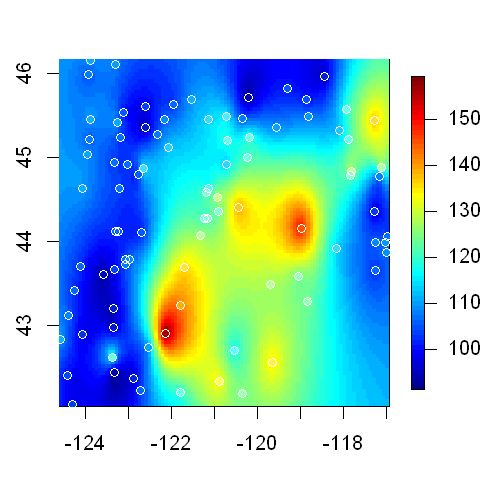

In [32]:
image.plot(lon0,lat0,matrix(pred$predict,100,100),zlim=range(y))
	cols <- matlab.like(100)[as.numeric(cut(y,breaks=100))]
	points(latlon,col=cols,pch=19)
	points(latlon,col='white')


### Exercise
Fit a bunch more variables

## Constructed spatial variables

### Exercise

## Model selection

In [69]:
dat <- data.frame(y=as.numeric(y),x=as.numeric(x),lat=M[,1],lon=M[,2])
fit1 <- gls(y ~ x, data=dat, correlation=corExp(form=~lat+lon,nugget=TRUE),method='ML')
fit2 <- gls(y ~ x, data=dat, correlation=corGaus(form=~lat+lon,nugget=TRUE),method='ML')
BIC(fit1,fit2)

,df,BIC
fit1,5,2595.148
fit2,5,2594.848


In [70]:
dat <- data.frame(y=as.numeric(y),x=as.numeric(x),x2=as.numeric(x^2),lat=M[,1],lon=M[,2])
fit1 <- gls(y ~ x,      data=dat, correlation=corExp(form=~lat+lon,nugget=TRUE),method='ML')
fit2 <- gls(y ~ x + x2, data=dat, correlation=corExp(form=~lat+lon,nugget=TRUE),method='ML')
BIC(fit1,fit2)

,df,BIC
fit1,5,2595.148
fit2,6,2601.789


### Exercise